# Quantitative Analysis of Price & Daily Returns
* Can returns be described with a normal distribution?
* Is daily change non-zero?
* Can price movement be described as a random walk?

### 1. Set up environment 

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 6
import seaborn as sb
sb.set()
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

### 2.  Download stock price data, store in dataframe

In [15]:
amzn = pdr.get_data_yahoo('AMZN')

[*********************100%***********************]  1 of 1 completed


### 3. Take a look at the data

In [16]:
amzn.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


### 4. Store instantaneous rate of return in separate series

In [18]:
amzn_return = round(np.log(amzn.Close).diff() * 100, 2)
amzn_return.dropna(inplace = True)
amzn_return.head()

Date
1997-05-16   -12.45
1997-05-19    -1.21
1997-05-20    -4.36
1997-05-21   -13.63
1997-05-22    -2.21
Name: Close, dtype: float64

### 5. Plot the series 

<AxesSubplot: xlabel='Date'>

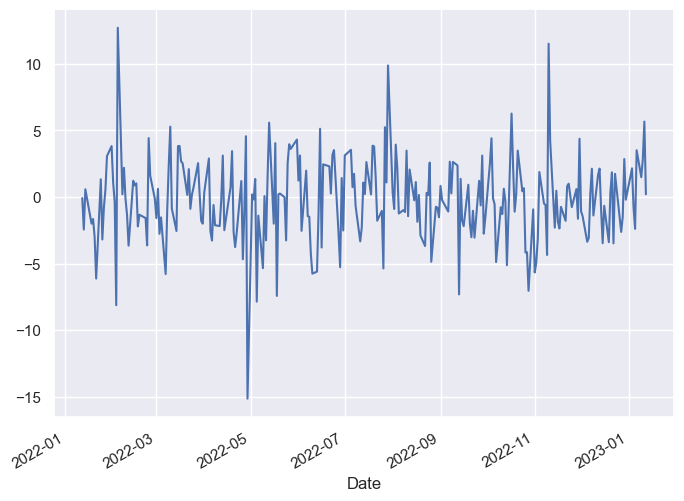

In [19]:
amzn_return[-252:].plot()

### 6. Pandas describe function gives descriptive statistics, default assumes you are dealing with a sample Pandas also deals with missing values by omitting them 

In [9]:
amzn_return.describe()

count    1257.000000
mean        0.118767
std         1.828797
min        -8.250000
25%        -0.710000
50%         0.150000
75%         1.040000
max        12.410000
Name: Close, dtype: float64

### 7. An alternative more slightly  different table of descriptives from scipy stats

In [22]:
from scipy import stats

In [23]:
n, minmax, mean, var, skew, kurt = stats.describe(amzn_return)
mini, maxi = minmax
std = var ** .5

### 9. for comparision generate random numbers that follow normal distribution


In [24]:
from scipy.stats import norm

In [25]:
x = norm.rvs(mean, std, n)

In [26]:
stats.describe(x)

DescribeResult(nobs=6458, minmax=(-17.50761198236238, 13.663295778119481), mean=0.09203507061382844, variance=13.143513167902315, skewness=0.004316624104946504, kurtosis=0.09763860700254634)

(array([1.000e+00, 0.000e+00, 5.000e+00, 2.500e+01, 1.260e+02, 3.520e+02,
        7.780e+02, 1.263e+03, 1.441e+03, 1.245e+03, 7.600e+02, 3.110e+02,
        1.190e+02, 2.600e+01, 6.000e+00]),
 array([-17.50761198, -15.42955146, -13.35149095, -11.27343043,
         -9.19536991,  -7.1173094 ,  -5.03924888,  -2.96118836,
         -0.88312784,   1.19493267,   3.27299319,   5.35105371,
          7.42911423,   9.50717474,  11.58523526,  13.66329578]),
 <BarContainer object of 15 artists>)

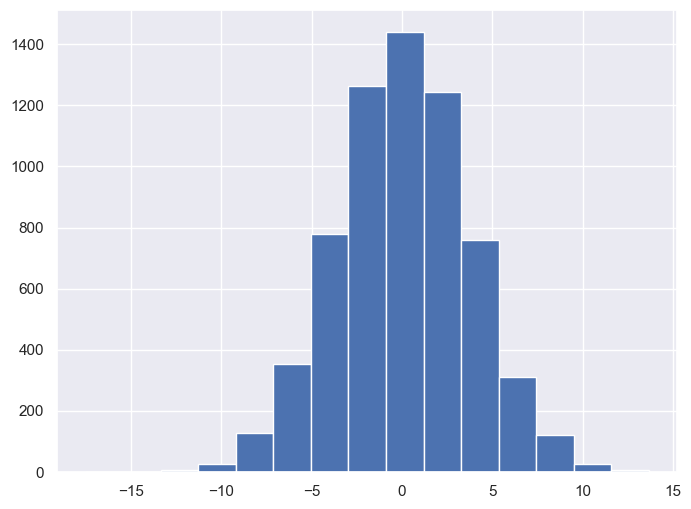

In [27]:
plt.hist(x, bins=15)

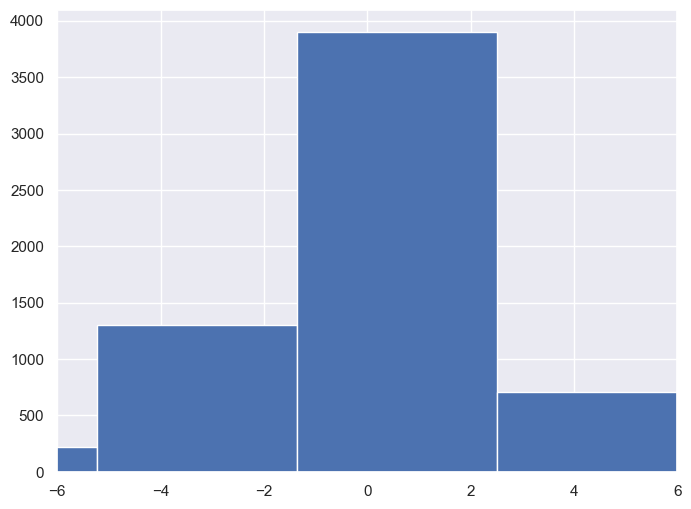

In [28]:
plt.hist(amzn_return, bins = 15)
plt.xlim(-6,6);

## Is price change normally distributed?

### 10. Use scipy stats to test the kurtosis, the null hypothesis is that the sample is drawn from a population where the underlying kurtosis is that of a normally distributed variable

In [29]:
x_test = stats.kurtosistest(x)
amzn_test = stats.kurtosistest(amzn_return)
print(f'{"     Test statistic":20}{"p-value":>15}')
print(f'{" "*5}{"-"* 30}')
print(f"x:{x_test[0]:>17.2f}{x_test[1]:16.4f}")
print(f"AMZN: {amzn_test[0]:13.2f}{amzn_test[1]:16.4f}")

     Test statistic         p-value
     ------------------------------
x:             1.58          0.1150
AMZN:         32.81          0.0000


### 11. plot histogram of price changes with normal curve overlay


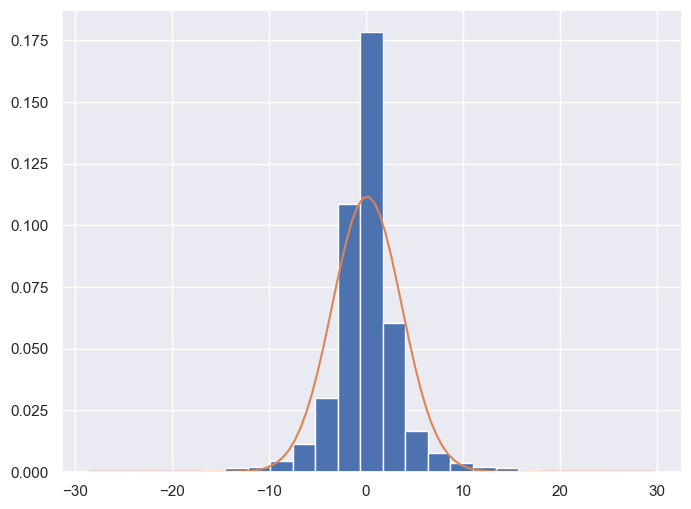

In [30]:
plt.hist(amzn_return, bins = 25, edgecolor='w', density= True)
data = np.linspace(mini, maxi, 100)
plt.plot(data, norm.pdf(data, mean, std));

### 12. Compare normally distributed sample with same attributes as amzn price change

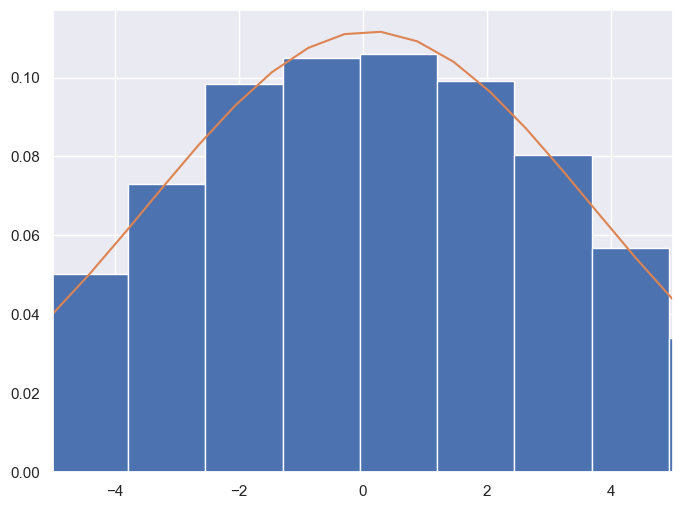

In [31]:
plt.hist(x, bins =25, density = True)
b = np.linspace(mini, maxi, 100)
plt.plot(b,stats.norm.pdf(b, mean, std))
plt.xlim(-5,5);

## Is daily price change significantly different from zero?

### 13. Conduct simple hypothesis test

In [32]:
stats.ttest_1samp(amzn_return.sample(252), 0, alternative='two-sided')

TtestResult(statistic=1.4012740057734359, pvalue=0.1623673709236194, df=251)

## Can price movement be described as a random walk?

### 14. Create price lags

In [33]:
amzn_close = pd.DataFrame(amzn.Close, columns= ['Close'])
amzn_close['lag_1'] = amzn_close.Close.shift(1)
amzn_close['lag_2'] = amzn_close.Close.shift(2)
amzn_close.dropna(inplace = True)
amzn_close.head()

,Close,lag_1,lag_2
Date,,,
1997-05-19,0.085417,0.086458,0.097917
1997-05-20,0.081771,0.085417,0.086458
1997-05-21,0.071354,0.081771,0.085417
1997-05-22,0.069792,0.071354,0.081771
1997-05-23,0.075000,0.069792,0.071354


### 15. Fit linear model

In [34]:
lr = np.linalg.lstsq(amzn_close[['lag_1', 'lag_2']], amzn_close.Close, rcond=None)[0]

In [35]:
amzn_close['predict'] = np.dot(amzn_close[['lag_1', 'lag_2']], lr)

In [36]:
amzn_close.head()

,Close,lag_1,lag_2,predict
Date,,,,
1997-05-19,0.085417,0.086458,0.097917,0.086645
1997-05-20,0.081771,0.085417,0.086458,0.085433
1997-05-21,0.071354,0.081771,0.085417,0.081830
1997-05-22,0.069792,0.071354,0.081771,0.071524
1997-05-23,0.075000,0.069792,0.071354,0.069817


<AxesSubplot: xlabel='Date'>

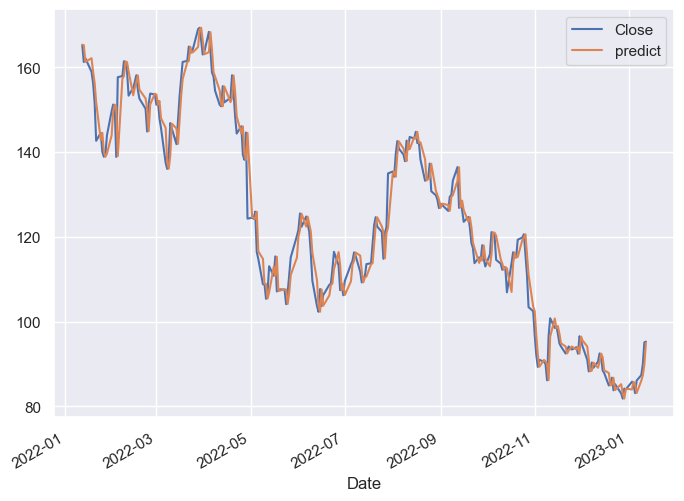

In [37]:
amzn_close.iloc[-252:][['Close', 'predict']].plot()